In [1]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [2]:
def parse_file(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        content = f.read()

    blocks = re.split(r"Performance counter stats for 'system wide':", content)
    rows = []

    # From this point on, GPT was used as a programming aid. The format of the results file was given as context.
    # The regular expressions are copied directly from the language model
    def clean_float(s):
        return float(s.replace('\u202F', '').replace(' ', '').replace(',', '.'))

    def clean_int(s):
        return int(s.replace('\u202F', '').replace(' ', ''))

    # Here, a combination of my own work and GPT was used
    for block in blocks[1:]:
        pkg_match = re.search(r"([\d,]+) Joules power/energy-pkg/", block)
        core_match = re.search(r"([\d,]+) Joules power/energy-cores/", block)
        cycles_match = re.search(r"([\d\s\u202F]+) +cycles", block)
        instr_match = re.search(r"([\d\s\u202F]+) +instructions", block)
        cache_ref_match = re.search(r"([\d\s\u202F]+) +cache-references", block)
        cache_miss_match = re.search(r"([\d\s\u202F]+) +cache-misses", block)
        cs_match = re.search(r"([\d\s\u202F]+) +cs", block)
        migrations_match = re.search(r"([\d\s\u202F]+) +migrations", block)
        pf_match = re.search(r"([\d\s\u202F]+) +page-faults", block)

        data = {
            "energy_pkg": clean_float(pkg_match.group(1)),
            "energy_cores": clean_float(core_match.group(1)),
            "cycles": clean_int(cycles_match.group(1)),
            "instructions": clean_int(instr_match.group(1)),
            "cache_references": clean_int(cache_ref_match.group(1)),
            "cache_misses": clean_int(cache_miss_match.group(1)),
            "cs": clean_int(cs_match.group(1)),
            "migrations": clean_int(migrations_match.group(1)),
            "page_faults": clean_int(pf_match.group(1)),
        }
        rows.append(data)

    return rows


In [3]:
all_rows = []

# Create dataframe for main tests

test_file_names = [
    "test_leo_skeleton_base_empty.txt",
    "test_leo_skeleton_base_long.txt",
    "test_leo_skeleton_base_medium.txt",
    "test_leo_skeleton_change_empty.txt",
    "test_leo_skeleton_change_long.txt", 
    "test_leo_skeleton_change_medium.txt", 
    "test_leo_skeleton_change+logging_long.txt",
    "test_leo_skeleton_change+logging_medium.txt",
    "test_leo_skeleton_change+logging_empty.txt",
    "test_mu_skeleton_base_empty.txt",
    "test_mu_skeleton_base_long.txt",
    "test_mu_skeleton_base_medium.txt",
    "test_mu_skeleton_change_empty.txt",
    "test_mu_skeleton_change_long.txt",
    "test_mu_skeleton_change_medium.txt",
    "test_mu_skeleton_change+logging_long.txt",
    "test_mu_skeleton_change+logging_medium.txt",
    "test_mu_skeleton_change+logging_empty.txt",
    "test_novelWriter_skeleton_base_empty.txt",
    "test_novelWriter_skeleton_base_long.txt",
    "test_novelWriter_skeleton_base_medium.txt",
    "test_novelWriter_skeleton_change_empty.txt",
    "test_novelWriter_skeleton_change_long.txt",
    "test_novelWriter_skeleton_change_medium.txt",
    "test_novelWriter_skeleton_change+logging_long.txt",
    "test_novelWriter_skeleton_change+logging_medium.txt",
    "test_novelWriter_skeleton_change+logging_empty.txt"
]
for file in test_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
original_df = pd.DataFrame(all_rows)

# GPT written below:
# Add new columns for app, variant and size grouping
original_df[['app', 'variant', 'size']] = (
    original_df['test'].str.extract(r'test_(?P<app>[a-zA-Z]+)_skeleton_(?P<variant>[^_]+)_(?P<size>empty|medium|long)')
)

print(original_df.head(10))

   energy_pkg  energy_cores      cycles  instructions  cache_references  \
0       58.15          2.62  1205632822     420613620          47533145   
1       45.54          2.41  1172328882     358697847          44816818   
2       53.22          2.33  1145813786     363630064          44353035   
3       56.20          2.78  1288981070     374030561          47821323   
4       61.27          2.63  1296263687     541997216          47250695   
5       62.07          2.42  1166862379     360993520          45594577   
6       55.56          2.36  1164006373     352163462          44268202   
7       58.49          2.41  1240766886     434766567          45593474   
8       55.31          2.80  1303753001     554700304          46004282   
9       56.28          2.50  1195266861     373586452          45852171   

   cache_misses     cs  migrations  page_faults                          test  \
0      23117788  11333          66         1120  test_leo_skeleton_base_empty   
1      22199

In [4]:
all_rows = []

# Create dataframe for control tests

control_file_names = [
    "control_test_empty.txt",
    "control_test_medium.txt",
    "control_test_long.txt"
]
for file in control_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
control_df = pd.DataFrame(all_rows)


control_df["size"] = control_df["test"].str.extract(r'_(empty|medium|long)$', expand=False)


In [5]:
overall_pkg = control_df['energy_pkg'].agg(['mean', 'min', 'max'])

per_size_pkg = (control_df.groupby('size')['energy_pkg'].agg(['mean', 'min', 'max']))

per_size_pkg

,mean,min,max
size,,,
empty,47.767333,39.19,64.39
long,46.542000,39.50,63.53
medium,50.271333,40.14,71.53


In [6]:
# Initial code based off: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
# ChatGPT was used to fix initial problems in this function
def drop_iqr_outliers(df, value_col='energy_pkg', by='test', k=1.5):
    keep_idx = []
    for _, grp in df.groupby(by):
        q1  = grp[value_col].quantile(0.25)
        q3  = grp[value_col].quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k*iqr, q3 + k*iqr
        keep_idx.extend(grp[(grp[value_col] >= lo) & (grp[value_col] <= hi)].index)
    return df.loc[keep_idx]

In [7]:
before = len(control_df)
control_df = drop_iqr_outliers(control_df, value_col='energy_pkg', by='test')
after  = len(control_df)

print(f"Outlier removal: dropped {before - after} rows "
      f"({after}/{before} observations kept).")

metrics = [c for c in control_df.columns if c not in ("test", "run", "size")]

control_means = control_df.groupby("size")[metrics].mean()

print(control_means)

Outlier removal: dropped 5 rows (85/90 observations kept).
        energy_pkg  energy_cores        cycles  instructions  \
size                                                           
empty    47.194138      2.574138  1.276917e+09  5.516951e+08   
long     45.956207      2.432069  1.280252e+09  6.086390e+08   
medium   48.092963      2.461852  1.290471e+09  6.106433e+08   

        cache_references  cache_misses            cs  migrations  page_faults  
size                                                                           
empty       4.355920e+07  2.135911e+07  10269.758621   70.620690  1315.172414  
long        4.526491e+07  2.218618e+07  11394.517241  239.379310  1491.000000  
medium      4.522231e+07  2.231826e+07  11504.407407  232.962963  1464.481481  


In [8]:
test_df = original_df.copy(deep=True)

# Subtract control from each test
for m in metrics:
    test_df[m] -= test_df["size"].map(control_means[m])

test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.955862,0.045862,-7.128444e+07,-1.310814e+08,3.973945e+06,1.758675e+06,1063.241379,-4.62069,-195.172414,test_leo_skeleton_base_empty,1,leo,base,empty
1,-1.654138,-0.164138,-1.045884e+08,-1.929972e+08,1.257618e+06,8.406948e+05,783.241379,-22.62069,-1114.172414,test_leo_skeleton_base_empty,2,leo,base,empty
2,6.025862,-0.244138,-1.311035e+08,-1.880650e+08,7.938347e+05,8.174968e+05,658.241379,1.37931,-442.172414,test_leo_skeleton_base_empty,3,leo,base,empty
3,9.005862,0.205862,1.206381e+07,-1.776645e+08,4.262123e+06,2.198618e+06,1256.241379,-8.62069,-1139.172414,test_leo_skeleton_base_empty,4,leo,base,empty
4,14.075862,0.055862,1.934642e+07,-9.697853e+06,3.691495e+06,1.509456e+06,1306.241379,15.37931,1002.827586,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,13.245862,-0.124138,-1.200604e+08,-1.859512e+08,1.327008e+06,8.283878e+05,762.241379,-0.62069,-1075.172414,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.715862,0.095862,-1.473773e+08,-2.043928e+08,8.873497e+05,6.818188e+05,491.241379,-16.62069,-528.172414,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.585862,0.185862,3.260365e+07,-1.142549e+07,2.891547e+06,1.791319e+06,1043.241379,23.37931,872.827586,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.905862,-0.124138,-1.009232e+08,-2.177730e+08,2.939677e+05,9.244968e+05,614.241379,10.37931,-1227.172414,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [9]:
before = len(test_df)
test_df = drop_iqr_outliers(test_df, value_col='energy_pkg', by='test')
after  = len(test_df)

print(f"Outlier removal: dropped {before - after} rows "
      f"({after}/{before} observations kept).")

Outlier removal: dropped 15 rows (795/810 observations kept).


In [10]:
#test_df.to_csv("test_results.csv")

In [11]:
# Test for normality - Shapiro-Wilk test

shapiro_results = []
for name, grp in test_df.groupby("test"):
    stat, p = shapiro(grp["energy_pkg"])
    shapiro_results.append({"test": name, "stat": stat, "p": p})
norm_df = pd.DataFrame(shapiro_results)

print(norm_df)

alpha = 0.05

norm_df['is_normal'] = norm_df['p'] > alpha

normal_tests = norm_df[norm_df['is_normal']]['test'].tolist()
print("Test cases that are normally distributed (p > 0.05):")
for t in normal_tests:
    print(f"- {t}")

                                               test      stat         p
0                      test_leo_skeleton_base_empty  0.979687  0.817173
1                       test_leo_skeleton_base_long  0.972109  0.638118
2                     test_leo_skeleton_base_medium  0.963117  0.391265
3            test_leo_skeleton_change+logging_empty  0.964868  0.430282
4             test_leo_skeleton_change+logging_long  0.955131  0.231478
5           test_leo_skeleton_change+logging_medium  0.945234  0.125869
6                    test_leo_skeleton_change_empty  0.977793  0.794644
7                     test_leo_skeleton_change_long  0.954016  0.216294
8                   test_leo_skeleton_change_medium  0.926824  0.040461
9                       test_mu_skeleton_base_empty  0.944843  0.134281
10                       test_mu_skeleton_base_long  0.948513  0.154226
11                     test_mu_skeleton_base_medium  0.905886  0.018286
12            test_mu_skeleton_change+logging_empty  0.955932  0

In [12]:
test_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,7.450862,-0.093805,-7.369024e+07,-1.595932e+08,2.110577e+06,1.018345e+06,894.041379,0.512644,-533.605747
test_leo_skeleton_base_long,11.766293,0.332574,1.330453e+08,8.491786e+07,4.444990e+06,2.176876e+06,1506.947044,-118.915025,117.071429
test_leo_skeleton_base_medium,9.525658,0.321941,1.306982e+08,1.036433e+08,4.725364e+06,2.053652e+06,1345.489144,-108.893997,686.415070
test_leo_skeleton_change+logging_empty,8.773103,-0.184828,-1.211005e+08,-1.836567e+08,5.995722e+05,-5.810731e+04,539.068966,-10.275862,-777.137931
test_leo_skeleton_change+logging_long,11.659460,0.212931,7.412842e+07,4.727737e+07,1.675648e+06,6.209070e+05,1107.116092,-118.245977,46.466667
test_leo_skeleton_change+logging_medium,9.132704,0.148148,5.475758e+07,4.135642e+07,2.100765e+06,4.402463e+05,962.025926,-115.396296,-33.381481
test_leo_skeleton_change_empty,5.823362,-0.127709,-1.038168e+08,-1.766682e+08,7.179185e+05,7.832660e+05,562.955665,-9.549261,-675.100985
test_leo_skeleton_change_long,13.989126,0.714264,3.465401e+08,3.014122e+08,1.249660e+07,5.554690e+06,1464.416092,-118.145977,990.200000
test_leo_skeleton_change_medium,9.122370,0.695815,3.307328e+08,2.958707e+08,1.136974e+07,5.417720e+06,1353.292593,-108.829630,1185.918519


In [53]:
# in-app comparison
# using delta of base test - control test
# repeat this for each application and file size
# repeat for different measured things (e.g. instructions or other energy cores)

# ChatGPT was used as an assistant to find general implementations of the statistical tests

alpha = 0.05

groups_in_app = {
    "base": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_base_empty","energy_pkg"].values,
    "change": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_change_empty","energy_pkg"].values,
    "change+logging": test_df.loc[test_df["test"]=="test_novelWriter_skeleton_change+logging_empty","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_in_app.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_in_app.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_in_app.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_in_app.keys()), [len(g) for g in groups_in_app.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_in_app.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #F, p_main = f_oneway(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #H, p_main = kruskal(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
base : W= 0.988 p= 0.975 - normal
change : W= 0.962 p= 0.342 - normal
change+logging : W= 0.961 p= 0.326 - normal

Variance:
Levene’s test: W= 0.26542409025834196 , p= 0.767499385842842 - equal variance

ANOVA: F= 0.9288085784612808 , p= 0.3989051612153154 - no statistically significant difference

Tukey HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1     group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  base         change   0.3183 0.9813 -3.7879 4.4245  False
  base change+logging  -1.8547 0.5308 -5.9609 2.2515  False
change change+logging   -2.173 0.4205 -6.2792 1.9332  False
-----------------------------------------------------------


In [14]:
for name, arr in groups_in_app.items():
    print(name, len(arr), arr.mean())

base 30 12.867126436781605
change 29 7.256551724137929
change+logging 30 10.882793103448275


In [15]:
# between-app comparison
# using deltas instead of cumulative value
# Change variants are delta-d to that apps/sizes base case
# Change+logging variants are delta-d to that apps/sizes change case

metrics = [c for c in test_df.columns if c not in ("test", "run", "app", "variant", "size")]

base_means = (test_df[test_df["variant"] == "base"].groupby(["app", "size"])[metrics].mean())

change_means = (test_df[test_df["variant"] == "change"].groupby(["app", "size"])[metrics].mean())

adj_df = test_df.copy()

for idx, row in adj_df.iterrows():
    key = (row["app"], row["size"])

    if row["variant"] == "change":
        adj_df.loc[idx, metrics] -= base_means.loc[key]

    elif row["variant"] == "change+logging":
        adj_df.loc[idx, metrics] -= change_means.loc[key]

c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:
c:\Users\2020m\anaconda3\lib\site-packages\pandas\core\ops\common.py:121: FutureWarning: elementwise compari

In [16]:
#adj_df.to_csv("adjusted_results.csv")

In [17]:
adj_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.955862,0.045862,-7.128444e+07,-1.310814e+08,3.973945e+06,1.758675e+06,1063.241379,-4.62069,-195.172414,test_leo_skeleton_base_empty,1,leo,base,empty
1,-1.654138,-0.164138,-1.045884e+08,-1.929972e+08,1.257618e+06,8.406948e+05,783.241379,-22.62069,-1114.172414,test_leo_skeleton_base_empty,2,leo,base,empty
2,6.025862,-0.244138,-1.311035e+08,-1.880650e+08,7.938347e+05,8.174968e+05,658.241379,1.37931,-442.172414,test_leo_skeleton_base_empty,3,leo,base,empty
3,9.005862,0.205862,1.206381e+07,-1.776645e+08,4.262123e+06,2.198618e+06,1256.241379,-8.62069,-1139.172414,test_leo_skeleton_base_empty,4,leo,base,empty
4,14.075862,0.055862,1.934642e+07,-9.697853e+06,3.691495e+06,1.509456e+06,1306.241379,15.37931,1002.827586,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-6.131667,0.131000,1.020494e+08,-1.934869e+07,-4.740454e+05,3.091924e+05,372.766667,-7.60000,-320.833333,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-15.681667,-0.199000,3.881798e+07,9.251489e+06,-1.073841e+06,-6.547506e+05,-178.233333,24.40000,488.166667,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,-1.671667,-0.099000,-3.790982e+07,-4.448564e+07,-4.447198e+06,-7.641506e+05,-445.233333,-12.60000,-488.833333,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,-5.671667,-0.249000,-7.881055e+07,-4.948559e+07,-1.568194e+06,-1.222705e+06,-487.233333,4.40000,-496.833333,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


In [18]:
change_means

energy_pkg  energy_cores        cycles  instructions  \
app         size                                                           
leo         empty     5.823362     -0.127709 -1.038168e+08 -1.766682e+08   
            long     13.989126      0.714264  3.465401e+08  3.014122e+08   
            medium    9.122370      0.695815  3.307328e+08  2.958707e+08   
mu          empty     8.190862     -0.200805 -1.157161e+08 -1.773281e+08   
            long      7.256552      0.349655  1.241400e+08  9.813250e+07   
            medium   11.319704      0.653148  3.163442e+08  2.524881e+08   
novelWriter empty    10.557529      0.236529  1.175280e+08  2.600975e+07   
            long      8.897793      0.672931  3.153602e+08  2.503021e+08   
            medium    7.790608      0.208148  7.858668e+07  3.407403e+07   

                    cache_references  cache_misses           cs  migrations  \
app         size                                                              
leo         empty       7.179185e+05  7.832660e+05   562.955665   -9.549261   
            long        1.249660e+07  5.554690e+06  1464.416092 -118.145977   
            medium      1.136974e+07  5.417720e+06  1353.292593 -108.829630   
mu          empty       4.056232e+05 -4.027051e+04   587.908046   -8.287356   
            long        3.878475e+06  1.899275e+06  1190.344828 -125.655172   
            medium      1.043108e+07  4.702301e+06  1086.459259 -114.196296   
novelWriter empty       8.509353e+06  3.929740e+06   547.241379   -5.987356   
            long        1.064058e+07  5.238478e+06  1098.716092 -119.445977   
            medium      3.033432e+06  1.191638e+06   959.985450 -113.998677   

                    page_faults  
app         size                 
leo         empty   -675.100985  
            long     990.200000  
            medium  1185.918519  
mu          empty   -621.805747  
            long     735.172414  
            medium   840.085185  
novelWriter empty      0.960920  
            long     648.600000  
            medium  -200.838624

In [52]:
test_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,7.450862,-0.093805,-7.369024e+07,-1.595932e+08,2.110577e+06,1.018345e+06,894.041379,0.512644,-533.605747
test_leo_skeleton_base_long,11.766293,0.332574,1.330453e+08,8.491786e+07,4.444990e+06,2.176876e+06,1506.947044,-118.915025,117.071429
test_leo_skeleton_base_medium,9.525658,0.321941,1.306982e+08,1.036433e+08,4.725364e+06,2.053652e+06,1345.489144,-108.893997,686.415070
test_leo_skeleton_change+logging_empty,8.773103,-0.184828,-1.211005e+08,-1.836567e+08,5.995722e+05,-5.810731e+04,539.068966,-10.275862,-777.137931
test_leo_skeleton_change+logging_long,11.659460,0.212931,7.412842e+07,4.727737e+07,1.675648e+06,6.209070e+05,1107.116092,-118.245977,46.466667
test_leo_skeleton_change+logging_medium,9.132704,0.148148,5.475758e+07,4.135642e+07,2.100765e+06,4.402463e+05,962.025926,-115.396296,-33.381481
test_leo_skeleton_change_empty,5.823362,-0.127709,-1.038168e+08,-1.766682e+08,7.179185e+05,7.832660e+05,562.955665,-9.549261,-675.100985
test_leo_skeleton_change_long,13.989126,0.714264,3.465401e+08,3.014122e+08,1.249660e+07,5.554690e+06,1464.416092,-118.145977,990.200000
test_leo_skeleton_change_medium,9.122370,0.695815,3.307328e+08,2.958707e+08,1.136974e+07,5.417720e+06,1353.292593,-108.829630,1185.918519


In [20]:
test_df.groupby("test")[metrics].mean()

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults
test,,,,,,,,,
test_leo_skeleton_base_empty,7.450862,-0.093805,-7.369024e+07,-1.595932e+08,2.110577e+06,1.018345e+06,894.041379,0.512644,-533.605747
test_leo_skeleton_base_long,11.766293,0.332574,1.330453e+08,8.491786e+07,4.444990e+06,2.176876e+06,1506.947044,-118.915025,117.071429
test_leo_skeleton_base_medium,9.525658,0.321941,1.306982e+08,1.036433e+08,4.725364e+06,2.053652e+06,1345.489144,-108.893997,686.415070
test_leo_skeleton_change+logging_empty,8.773103,-0.184828,-1.211005e+08,-1.836567e+08,5.995722e+05,-5.810731e+04,539.068966,-10.275862,-777.137931
test_leo_skeleton_change+logging_long,11.659460,0.212931,7.412842e+07,4.727737e+07,1.675648e+06,6.209070e+05,1107.116092,-118.245977,46.466667
test_leo_skeleton_change+logging_medium,9.132704,0.148148,5.475758e+07,4.135642e+07,2.100765e+06,4.402463e+05,962.025926,-115.396296,-33.381481
test_leo_skeleton_change_empty,5.823362,-0.127709,-1.038168e+08,-1.766682e+08,7.179185e+05,7.832660e+05,562.955665,-9.549261,-675.100985
test_leo_skeleton_change_long,13.989126,0.714264,3.465401e+08,3.014122e+08,1.249660e+07,5.554690e+06,1464.416092,-118.145977,990.200000
test_leo_skeleton_change_medium,9.122370,0.695815,3.307328e+08,2.958707e+08,1.136974e+07,5.417720e+06,1353.292593,-108.829630,1185.918519


In [21]:
# Exact same code as above, just copied again to differentiate type of result

alpha = 0.05

groups_between_apps = {
    "nw": adj_df.loc[adj_df["test"]=="test_novelWriter_skeleton_change_long","energy_pkg"].values,
    "mu": adj_df.loc[adj_df["test"]=="test_mu_skeleton_change_long","energy_pkg"].values,
    "leo": adj_df.loc[adj_df["test"]=="test_leo_skeleton_change_long","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_between_apps.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_between_apps.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_between_apps.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_between_apps.keys()), [len(g) for g in groups_between_apps.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_between_apps.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    #F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    F, p_main = f_oneway(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    #H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    H, p_main = kruskal(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
nw : W= 0.968 p= 0.489 - normal
mu : W= 0.962 p= 0.362 - normal
leo : W= 0.954 p= 0.216 - normal

Variance:
Levene’s test: W= 0.7251112849402179 , p= 0.48720740496663695 - equal variance

ANOVA: F= 9.885701371929569 , p= 0.00013664635472701125 - statistically significant difference

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   leo     mu  -7.8334 0.0001 -12.097 -3.5698   True
   leo     nw  -5.0138 0.0159 -9.2412 -0.7865   True
    mu     nw   2.8196  0.261 -1.4441  7.0832  False
----------------------------------------------------


In [22]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.955862,0.045862,-7.128444e+07,-1.310814e+08,3.973945e+06,1.758675e+06,1063.241379,-4.620690,-195.172414,test_leo_skeleton_base_empty,1,leo,base,empty
1,-1.654138,-0.164138,-1.045884e+08,-1.929972e+08,1.257618e+06,8.406948e+05,783.241379,-22.620690,-1114.172414,test_leo_skeleton_base_empty,2,leo,base,empty
2,6.025862,-0.244138,-1.311035e+08,-1.880650e+08,7.938347e+05,8.174968e+05,658.241379,1.379310,-442.172414,test_leo_skeleton_base_empty,3,leo,base,empty
3,9.005862,0.205862,1.206381e+07,-1.776645e+08,4.262123e+06,2.198618e+06,1256.241379,-8.620690,-1139.172414,test_leo_skeleton_base_empty,4,leo,base,empty
4,14.075862,0.055862,1.934642e+07,-9.697853e+06,3.691495e+06,1.509456e+06,1306.241379,15.379310,1002.827586,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,6.197037,0.398148,1.854735e+08,4.008314e+07,3.473547e+06,2.041204e+06,1593.592593,-111.962963,-341.481481,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-3.352963,0.068148,1.222421e+08,6.868332e+07,2.873751e+06,1.077261e+06,1042.592593,-79.962963,467.518519,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,10.657037,0.168148,4.551426e+07,1.494619e+07,-4.996062e+05,9.678608e+05,775.592593,-116.962963,-509.481481,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,6.657037,0.018148,4.613525e+06,9.946242e+06,2.379398e+06,5.093068e+05,733.592593,-99.962963,-517.481481,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


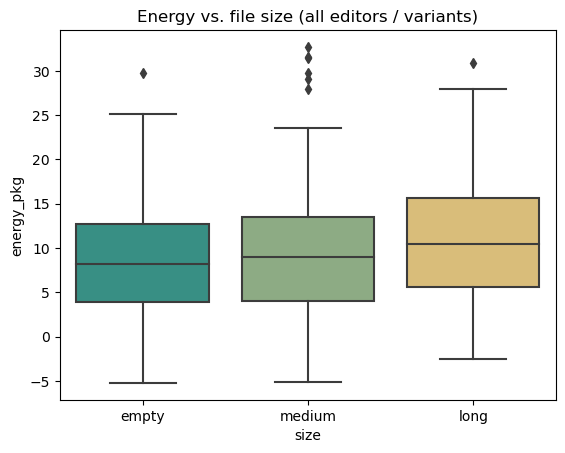

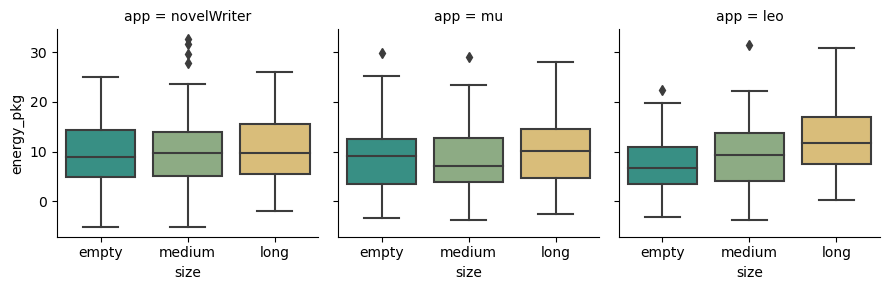

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# following website was used https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/

size_order = pd.CategoricalDtype(['empty', 'medium', 'long'], ordered=True)
app_order  = pd.CategoricalDtype(['novelWriter', 'mu', 'leo'], ordered=True)
df = test_df.copy()
df['size'] = df['size'].astype(size_order)
df['app']  = df['app'].astype(app_order)
df['sizeNum'] = df['size'].cat.codes 

sns.boxplot(data=df, x='size', y='energy_pkg', palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
plt.title('Energy vs. file size (all editors / variants)')
plt.show()

sns.catplot(data=df, x='size', y='energy_pkg', col='app', col_order=app_order.categories, kind='box', height=3, aspect=1, palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
plt.show()

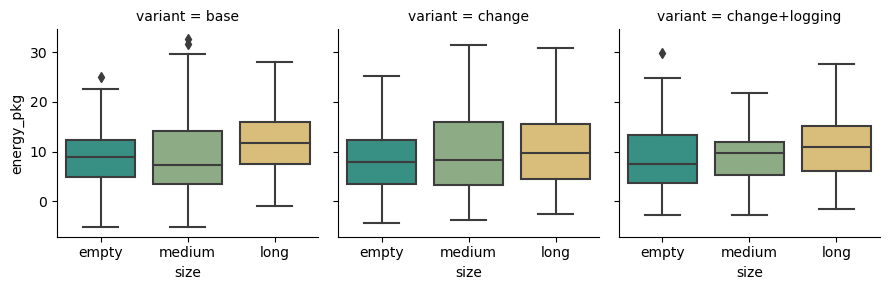

In [24]:
size_order = pd.CategoricalDtype(['empty', 'medium', 'long'], ordered=True)
app_order  = pd.CategoricalDtype(['base', 'change', 'change+logging'], ordered=True)
df = test_df.copy()
df['size'] = df['size'].astype(size_order)
df['variant']  = df['variant'].astype(app_order)
df['sizeNum'] = df['size'].cat.codes 

sns.catplot(data=df, x='size', y='energy_pkg', col='variant', col_order=app_order.categories, kind='box', height=3, aspect=1, palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
# Energy PKG by variant and file size
plt.show()

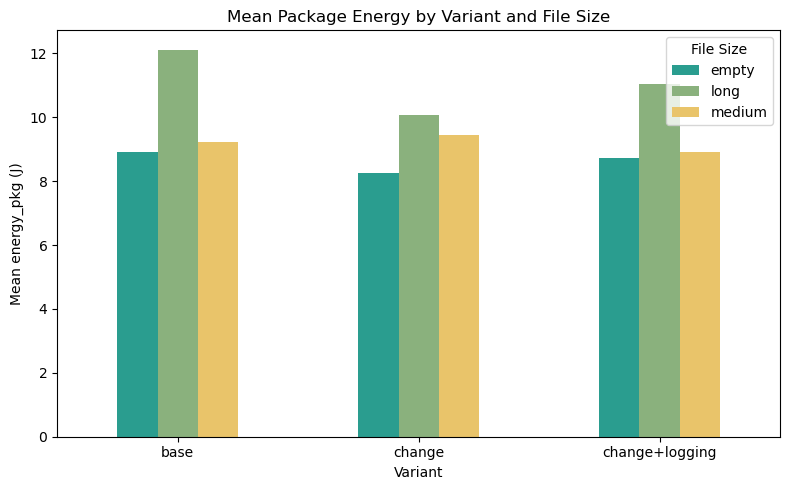

In [25]:
mean_energy = test_df.groupby(['variant', 'size'])['energy_pkg'].mean().unstack('size')

fig, ax = plt.subplots(figsize=(8, 5))
mean_energy.plot(kind='bar', ax=ax, color=["#2A9D8F", "#8AB17D", "#E9C46A"])
ax.set_xlabel('Variant')
ax.set_ylabel('Mean energy_pkg (J)')
ax.set_title('Mean Package Energy by Variant and File Size')
ax.legend(title='File Size')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
mean_energy

size,empty,long,medium
variant,,,
base,8.897997,12.115157,9.235642
change,8.244385,10.079186,9.447719
change+logging,8.736873,11.036015,8.926469


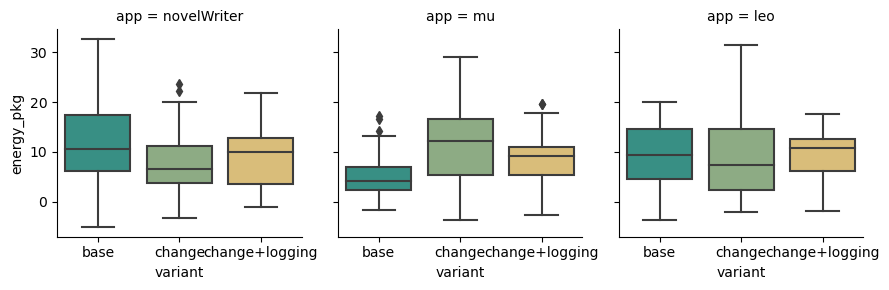

In [27]:
medium_df = test_df[test_df['size'] == 'medium']

variant_order = pd.CategoricalDtype(['base', 'change', 'change+logging'], ordered=True)
app_order  = pd.CategoricalDtype(['novelWriter', 'mu', 'leo'], ordered=True)
df = medium_df.copy()
df['variant'] = df['variant'].astype(variant_order)
df['app']  = df['app'].astype(app_order)
df['sizeNum'] = df['app'].cat.codes 

sns.catplot(data=df, x='variant', y='energy_pkg', col='app', col_order=app_order.categories, kind='box', height=3, aspect=1, palette=["#2A9D8F", "#8AB17D", "#E9C46A"])
# Energy PKG by App and Variant (Medium files)
plt.show()

In [44]:
(test_df[(test_df['size'] == 'long') & (test_df['app'] == 'mu')]
    .groupby('variant')['energy_pkg']
    .mean())

variant
base              12.867126
change             7.256552
change+logging    10.882793
Name: energy_pkg, dtype: float64

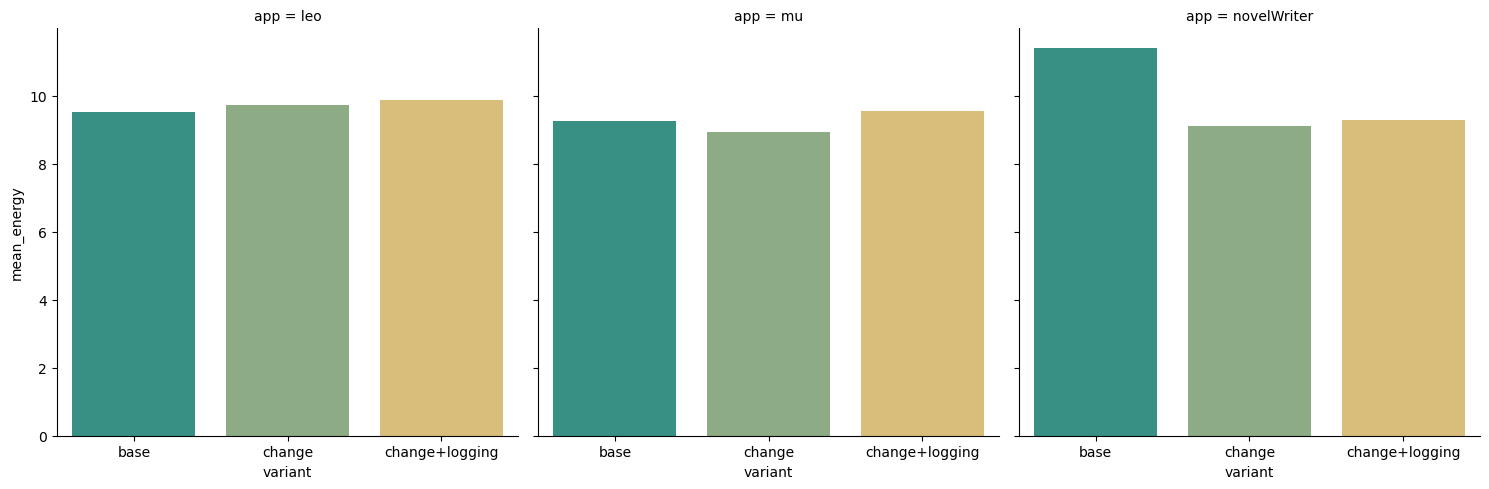

In [45]:
plot_df = (test_df
           .groupby(['app', 'variant'], as_index=False)
           .agg(mean_energy=('energy_pkg', 'mean')))

sns.catplot(data=plot_df,
            x='variant', y='mean_energy',
            col='app', kind='bar',
            palette=["#2A9D8F", "#8AB17D", "#E9C46A"])

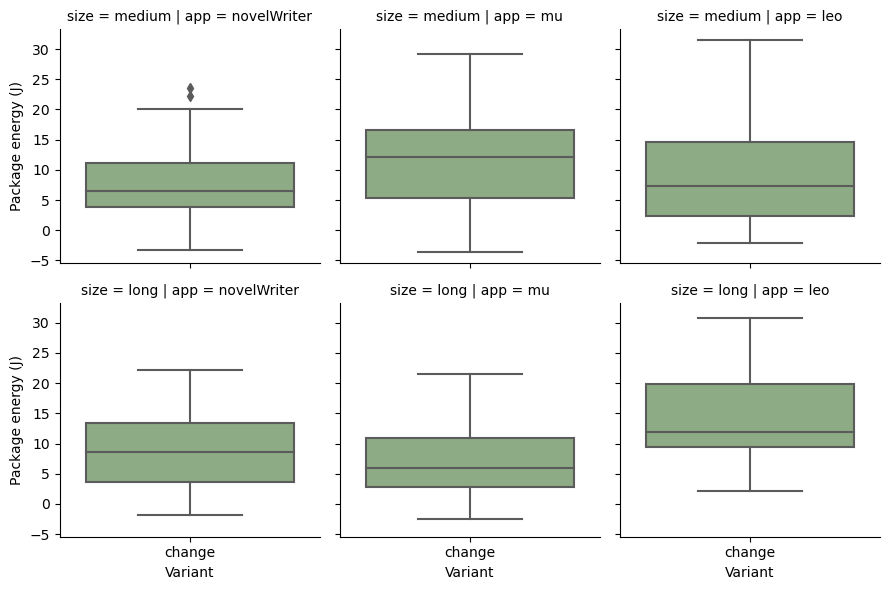

In [94]:
#variant_order = pd.CategoricalDtype(['base', 'change', 'change+logging'], ordered=True)
#app_order  = pd.CategoricalDtype(['novelWriter', 'mu', 'leo'], ordered=True)
#size_order = pd.CategoricalDtype(['empty', 'medium', 'long'], ordered=True)

variant_order = pd.CategoricalDtype(['change'], ordered=True)
app_order  = pd.CategoricalDtype(['novelWriter', 'mu', 'leo'], ordered=True)
size_order = pd.CategoricalDtype(['medium', 'long'], ordered=True)

df = test_df.copy()

df['variant'] = df['variant'].astype(variant_order)
df['variant'] = df['variant'].cat.rename_categories({'change+logging': 'logging'})
df['app']     = df['app'].astype(app_order)
df['size']    = df['size'].astype(size_order)

# GPT was used to figure out how to stack 3 plots of differennt file sizes
g = sns.catplot(
        data=df,
        x='variant', y='energy_pkg',
        col='app', col_order=app_order.categories,
        row='size', row_order=size_order.categories,
        kind='box',
        height=3, aspect=1,
        #palette=["#2A9D8F", "#8AB17D", "#E9C46A"]
        palette=["#8AB17D", "#E9C46A"]
)

g.set_axis_labels("Variant", "Package energy (J)")
#g.fig.subplots_adjust(top=0.92, hspace=0.3)
#g.fig.suptitle("Package-energy distribution by editor, variant and file-size")

plt.show()

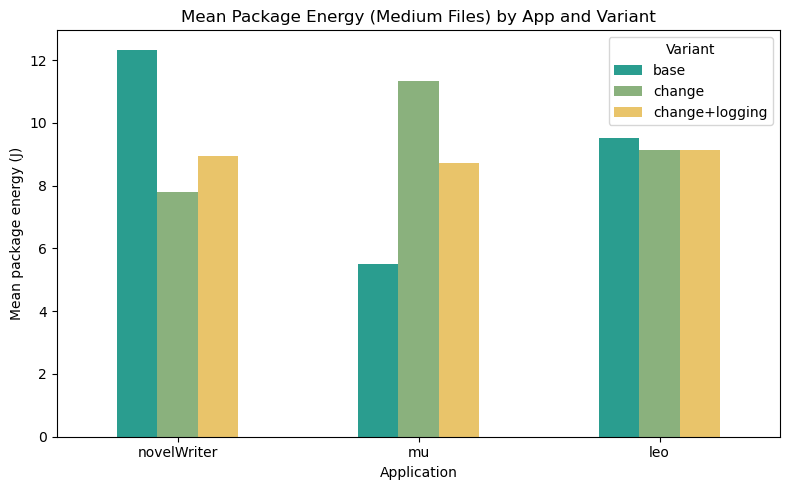

In [30]:
# GPT consulted on how to fix the order of the applications in the diagram

medium_df = test_df[test_df['size'] == 'medium']
order = ['novelWriter', 'mu', 'leo']

mean_energy = medium_df.groupby(['app', 'variant'])['energy_pkg'].mean().unstack('variant')
mean_energy = mean_energy.reindex(order)
fig, ax = plt.subplots(figsize=(8, 5))
mean_energy.plot(kind='bar', ax=ax, color=["#2A9D8F", "#8AB17D", "#E9C46A"])

ax.set_xlabel("Application")
ax.set_ylabel("Mean package energy (J)")
ax.set_title("Mean Package Energy (Medium Files) by App and Variant")
ax.legend(title="Variant")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.955862,0.045862,-7.128444e+07,-1.310814e+08,3.973945e+06,1.758675e+06,1063.241379,-4.620690,-195.172414,test_leo_skeleton_base_empty,1,leo,base,empty
1,-1.654138,-0.164138,-1.045884e+08,-1.929972e+08,1.257618e+06,8.406948e+05,783.241379,-22.620690,-1114.172414,test_leo_skeleton_base_empty,2,leo,base,empty
2,6.025862,-0.244138,-1.311035e+08,-1.880650e+08,7.938347e+05,8.174968e+05,658.241379,1.379310,-442.172414,test_leo_skeleton_base_empty,3,leo,base,empty
3,9.005862,0.205862,1.206381e+07,-1.776645e+08,4.262123e+06,2.198618e+06,1256.241379,-8.620690,-1139.172414,test_leo_skeleton_base_empty,4,leo,base,empty
4,14.075862,0.055862,1.934642e+07,-9.697853e+06,3.691495e+06,1.509456e+06,1306.241379,15.379310,1002.827586,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,6.197037,0.398148,1.854735e+08,4.008314e+07,3.473547e+06,2.041204e+06,1593.592593,-111.962963,-341.481481,test_novelWriter_skeleton_change_medium,26,novelWriter,change,medium
716,-3.352963,0.068148,1.222421e+08,6.868332e+07,2.873751e+06,1.077261e+06,1042.592593,-79.962963,467.518519,test_novelWriter_skeleton_change_medium,27,novelWriter,change,medium
717,10.657037,0.168148,4.551426e+07,1.494619e+07,-4.996062e+05,9.678608e+05,775.592593,-116.962963,-509.481481,test_novelWriter_skeleton_change_medium,28,novelWriter,change,medium
718,6.657037,0.018148,4.613525e+06,9.946242e+06,2.379398e+06,5.093068e+05,733.592593,-99.962963,-517.481481,test_novelWriter_skeleton_change_medium,29,novelWriter,change,medium


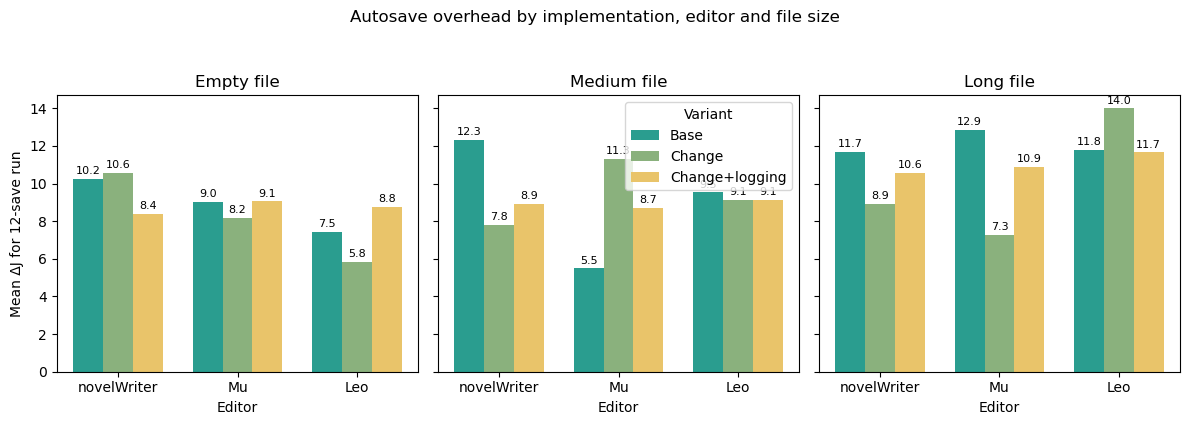

In [32]:
df = test_df.copy()
df['delta_pkg'] = df['energy_pkg']

order_sizes = ['empty', 'medium', 'long']
order_editors = ['novelWriter', 'mu', 'leo']
order_variants = ['base', 'change', 'change+logging']
colors = ["#2A9D8F", "#8AB17D", "#E9C46A"]
bar_width = 1

# A lot of help was used by GPT for the diagram below

g = (df.groupby(['size', 'app', 'variant'])['delta_pkg'].mean().reindex(
           pd.MultiIndex.from_product(
               [order_sizes, order_editors, order_variants],
               names=['size', 'app', 'variant']
           )
       )
       .reset_index())

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, sz in zip(axs, order_sizes):
    subset = g[g['size'] == sz]

    for i, editor in enumerate(order_editors):
        heights = (subset[subset['app'] == editor]
                   .set_index('variant')
                   .loc[order_variants, 'delta_pkg']
                   .values)
        x_base = i * 4

        for j, (variant, h) in enumerate(zip(order_variants, heights)):
            bar = ax.bar(x_base + j, h,
                         width=bar_width,
                         color=colors[j],
                         label=variant.capitalize() if i == 0 else None)
            ax.text(x_base + j, h + 0.15,
                    f'{h:.1f}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_title(f'{sz.capitalize()} file')
    ax.set_xticks([i * 4 + 1 for i in range(len(order_editors))])
    ax.set_xticklabels(['novelWriter', 'Mu', 'Leo'])
    ax.set_xlabel('Editor')

axs[0].set_ylabel('Mean ΔJ for 12-save run')
fig.suptitle('Autosave overhead by implementation, editor and file size', y=1.05)
axs[1].legend(title='Variant')
plt.tight_layout()
plt.show()